# A Review of Self-Explaining Neural Networks

Authors: *Rico Mossinkoff, Yke Rusticus, Roberto Schiavone, Ewoud Vermeij*

## Introduction

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from api.parameters import RegLambda, HType, NConcepts
from api.models import load_compas, load_mnist

from api import accuracy, explicitness, faithfulness, stability

100%|██████████| 6172/6172 [00:04<00:00, 1383.71it/s]


### MNIST

For the MNIST dataset, it is possible to load various models specifying the following parameters to the `load_mnist` function:
- `h_type=HType.INPUT` and `reg_lambda`
- `h_type=HType.CNN`, `reg_lambda` and `n_concepts`

If `load_mnist` is called with `h_type=HType.INPUT` and `n_concepts`, `n_concepts` is safely ignored.

The default parameters for MNIST are `h_type=HType.INPUT`, `n_concepts=NConcepts.FIVE` and `reg_lambda=RegLambda.E4`

### COMPAS

For the COMPAS dataset, the only parameter that is possible to specify is the `reg_lambda` coefficient. The default `reg_lambda` value is `RegLambda.E4`.

The available values for each possible parameter are shown below.

In [2]:
print('h_type possible values:')
for x in HType:
    print(x)

h_type possible values:
HType.CNN
HType.INPUT


In [3]:
print('reg_lambda possible values:')
for x in RegLambda:
    value = ('{:0.0e}' if x.value != 0 and x.value != 1 else '{}').format(x.value)
    print(str(x) + ': ' + value)

reg_lambda possible values:
RegLambda.ZERO: 0
RegLambda.E4: 1e-04
RegLambda.E3: 1e-03
RegLambda.E2: 1e-02
RegLambda.E1: 1e-01
RegLambda.ONE: 1


In [4]:
print('n_concepts possible values:')
for x in NConcepts:
    print(str(x) + ': ' + str(x.value))

n_concepts possible values:
NConcepts.FIVE: 5
NConcepts.TWENTY: 20


In [5]:
for x in RegLambda:
    print(x)

RegLambda.ZERO
RegLambda.E4
RegLambda.E3
RegLambda.E2
RegLambda.E1
RegLambda.ONE


In [6]:
# Create model dictionaries for each model configuration
compas_models = {}
mnist_input_models = {}
mnist_cnn_5concepts_models = {}
mnist_cnn_20concepts_models = {}

for l in RegLambda:
    compas_models[l.name] = load_compas(reg_lambda=l, show_specs=False)
    mnist_input_models[l.name] = load_mnist(reg_lambda=l, h_type=HType.INPUT, show_specs=False)
    mnist_cnn_5concepts_models[l.name] = load_mnist(reg_lambda=l, show_specs=False)
    mnist_cnn_20concepts_models[l.name] = load_mnist(reg_lambda=l, n_concepts=NConcepts.TWENTY, show_specs=False)

## Reproducibility

### Accuracy

Below all accuracies of all different model configurations can be found. All accuracies are on par with the accuracies of the original paper, except for the ones using $\lambda = 1$. Here a for us unexplainable drop in performance is shown.

In [7]:
#Create accuracy dictionaries for each model configuration (time consuming)
compas_accuracy = {}
mnist_input_accuracy = {}
mnist_cnn_5concepts_accuracy = {}
mnist_cnn_20concepts_accuracy = {}

for l in RegLambda:
    compas_accuracy[l.name] = accuracy.evaluate_compas(compas_models[l.name])
    mnist_input_accuracy[l.name] = accuracy.evaluate_mnist(mnist_input_models[l.name])
    mnist_cnn_5concepts_accuracy[l.name] = accuracy.evaluate_mnist(mnist_cnn_5concepts_models[l.name])
    mnist_cnn_20concepts_accuracy[l.name] = accuracy.evaluate_mnist(mnist_cnn_20concepts_models[l.name])

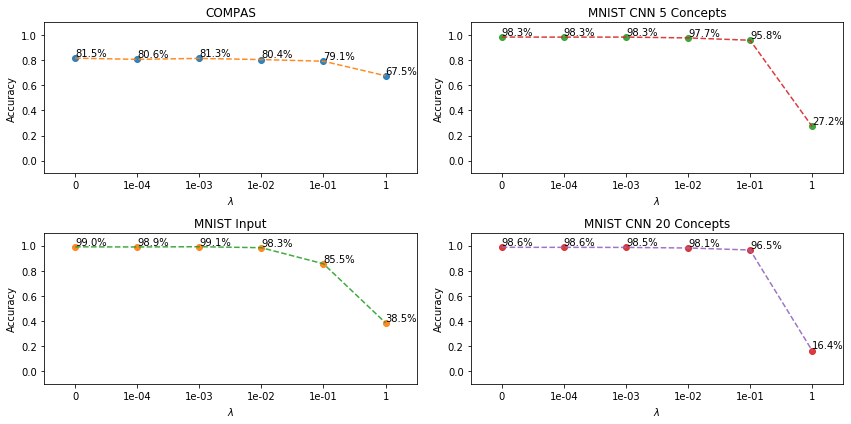

In [8]:
accuracies = [compas_accuracy, mnist_input_accuracy, mnist_cnn_5concepts_accuracy, mnist_cnn_20concepts_accuracy]
titles = ["COMPAS", "MNIST Input", "MNIST CNN 5 Concepts", "MNIST CNN 20 Concepts"]
accuracy.plot_accuracy_comparison(accuracies, titles)

### Explicitness/Intelligibility

The explainability plot shows a sample image from the MNIST datset on the left, the relevance scores produced by $\theta(x)$ in the middle and the prototypes of each basic concepts on the right. The idea is that high relevance score for a certain concept should indicate similarity between the sample image and the prototypes of that image. For our models, this is often not the case. Different models can be used in this function, including different setting for the number of prototypes and layout. 

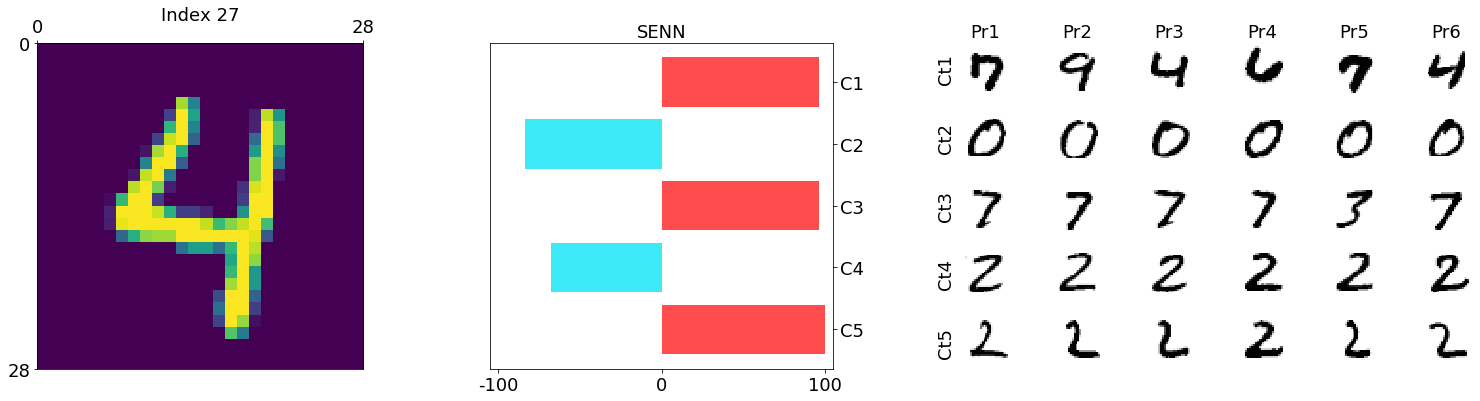

In [9]:
index = 27
explicitness.plot_digit_activation_concept_grid(mnist_cnn_5concepts_models['E1'], index, layout='horizontal')

### Extension - Synthetic images instead of prototypes

As an extension to the original paper, we defined a function that searches for image settings activating the concepts most, attempting to produces human interpretable concepts. Unfortunately, the synthetic images are not very human interpretable. Different settings are applied to visualize the synthetic images.

$\alpha$ is a regularization term pushing other concepts to 0 to a certain extend, making the current concept more strongly visible.

$\beta$ is a regularization term able to reduce the noise, as shown in the image below.

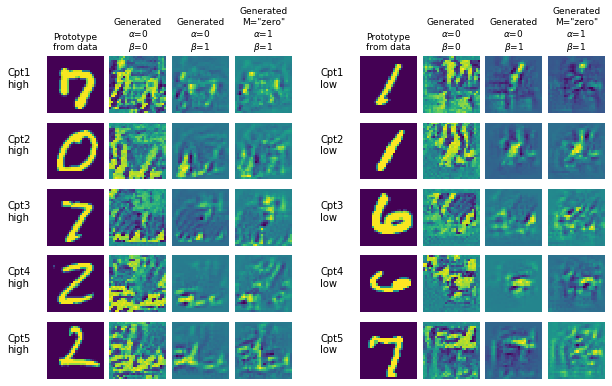

In [10]:
explicitness.visualize_concepts(mnist_cnn_5concepts_models['E1'],
                                             p1=[0,0,1],
                                             p2=[0,1,1],
                                             method=["zero"] * 3,
                                             x0=None,
                                             show_loss=False,
                                             print_freqs=[0, 0],
                                             best_of=1,
                                             compact=False)

### Faithfulness

The faithfullness of the concept describe how important the contribution of each concept is. In other words, what happens if we take one concept and remove. Below we can see a MNIST sample and the relevance score plotted per concept, indicated by the blue bars. In orange, The probability drop when the concept is removed. 

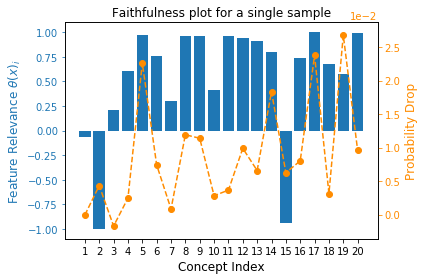

In [11]:
index = 36
faithfulness.plot_faithfulness(mnist_cnn_20concepts_models['E1'], index, show_h=False, show_htheta=False)

### Stability

The authors of the original paper describe a tradeoff between the model performance and the regularization strength on $\theta(x)$. The higher the regularization, the more linear (and therefor explanable) the model gets, the lower the predictive performance becomes. And vice versa. 

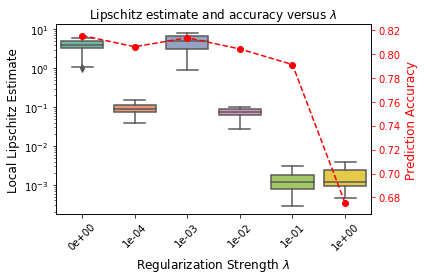

In [12]:
stability.plot_lipschitz_accuracy(models=list(compas_models.values()), 
                                  reg_lambdas=[l for l in RegLambda],
                                  accuracies=list(compas_accuracy.values()))

#### MNIST

To make sure that the model keeps it local linearity, small changes/perturbations should not have great influence on the relevance scores produced by $\theta(x)$. As shown below, for a regularized model the small perturbations have no influence on the relevance scores. Unregularized however, shows quite some difference in the relevance scores.

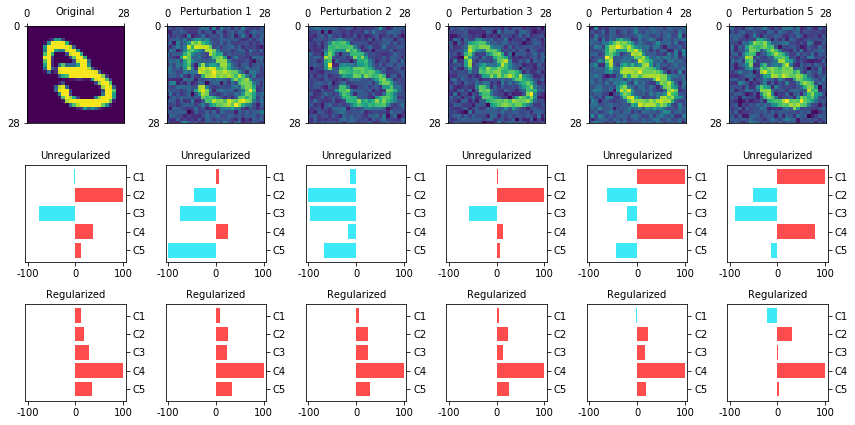

In [13]:
index = 18
model = mnist_cnn_5concepts_models[RegLambda.E1.name]
unregularized_model = mnist_cnn_5concepts_models[RegLambda.ZERO.name]
stability.plot_digit_noise_activation_regularized_unregularized(model, unregularized_model, index, 5)

#### COMPAS

As similar to the MNIST models, we applied a small change in the inputs to determine of the model is not influenced by it. In two settings we change the ethnicity from african american to other. It is shown that of the regularized model the relevance scores stay relatively the same, while the unregularized model is showing some differences. This can also contribute to the fairness of an algorithm, since ethnicity should not have ahuge impact on the recidivism scores. 

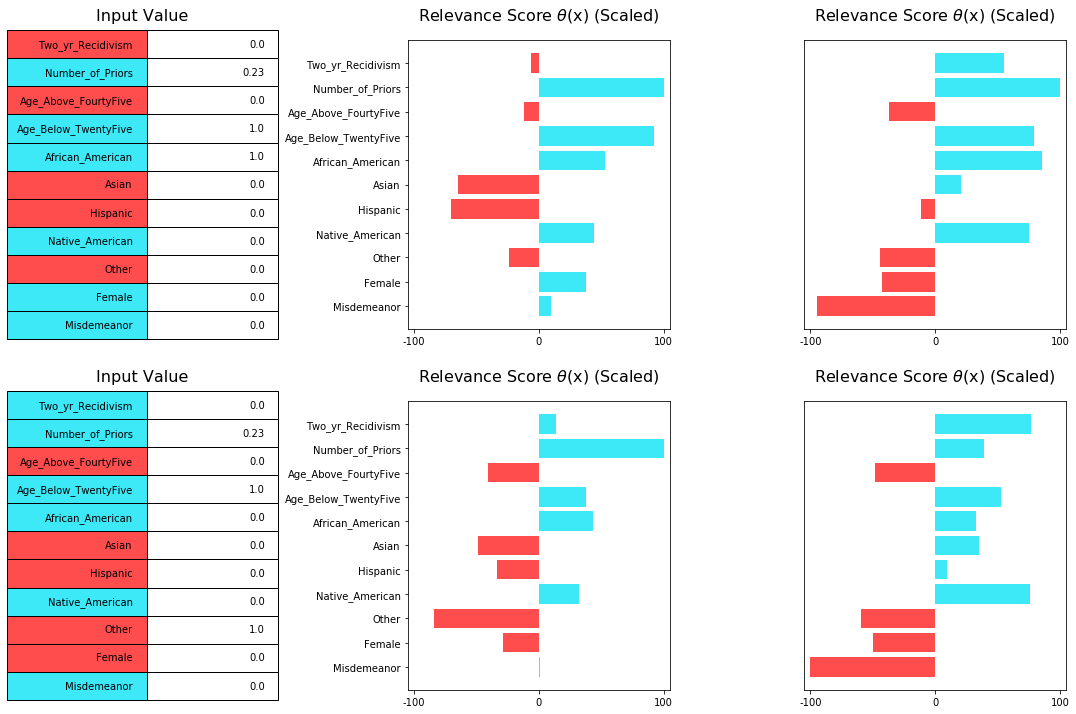

In [14]:
x = [
    0.,   # Two_yr_Recidivism
    0.23, # Number_of_Priors
    0.,   # Age_Above_FourtyFive
    1.,   # Age_Below_TwentyFive
    1.,   # African_American
    0.,   # Asian
    0.,   # Hispanic
    0.,   # Native_American
    0.,   # Other
    0.,   # Female
    0.,   # Misdemeanor
    ]

y = [
    0.,   # Two_yr_Recidivism
    0.23, # Number_of_Priors
    0.,   # Age_Above_FourtyFive
    1.,   # Age_Below_TwentyFive
    0.,   # African_American
    0.,   # Asian
    0.,   # Hispanic
    0.,   # Native_American
    1.,   # Other
    0.,   # Female
    0.,   # Misdemeanor
    ]

model = compas_models[RegLambda.E1.name]
unregularized_model = compas_models[RegLambda.ZERO.name]
stability.plot_input_values_regularized_unregularized_explanation(model, unregularized_model, [x, y])